In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np

In [3]:
# 数据读取和预处理
# mut_matrix是提供的突变矩阵，data_y是样本的疾病状态标签
data = pd.read_csv("./clean_data_final.csv")
data_y = data["overall_survival"]
mut_matrix = data.iloc[:,1:]

In [4]:
mut_matrix.values[:,]

array([[75.65,  2.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       [43.19,  4.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       [48.87,  5.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [62.9 ,  5.  ,  4.  , ...,  0.  ,  0.  ,  0.  ],
       [61.16,  5.  ,  4.  , ...,  0.  ,  0.  ,  0.  ],
       [60.02,  5.  ,  4.  , ...,  0.  ,  0.  ,  0.  ]])

In [5]:
# 数据集和批量大小
data = TensorDataset(torch.from_numpy(mut_matrix.values).float(), torch.from_numpy(data_y.values).float())
batch_size = 64
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [6]:
# 定义训练集和验证集的比例
train_ratio = 0.9
valid_ratio = 0.1

# 计算对应的数据量
train_size = int(train_ratio * len(data))
valid_size = len(data) - train_size

# 使用 random_split() 随机分配训练集和验证集
train_set, valid_set = random_split(data, [train_size, valid_size])

# 创建数据加载器
train_loader = DataLoader(train_set, batch_size=batch_size)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [7]:
valid_indices = valid_set.indices

In [8]:
# 定义VAE模型结构
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()

        # 定义编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid()
        )
        self.mean = nn.Linear(hidden_size, latent_size)
        self.log_var = nn.Linear(hidden_size, latent_size)

        # 定义解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mean = self.mean(h)
        log_var = self.log_var(h)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var


# 训练VAE模型
input_size = mut_matrix.shape[1]
hidden_size = 256
latent_size = 64
lr = 1e-3
num_epochs = 50

model = VAE(input_size, hidden_size, latent_size)
optimizer = Adam(model.parameters(), lr=lr)
# def loss_func(recon_x, x, mu, logvar):
#     BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD
loss_func = nn.BCELoss(reduction='sum')

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x_hat, mean, log_var = model(x)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        reconstruction_loss = loss_func(x_hat, x)
        loss = kl_divergence + reconstruction_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()/batch_size:.4f}")


Epoch [1/50], Step [10/27], Loss: -489.2555
Epoch [1/50], Step [20/27], Loss: -9684.9824
Epoch [2/50], Step [10/27], Loss: -9200.0146
Epoch [2/50], Step [20/27], Loss: -10282.1738
Epoch [3/50], Step [10/27], Loss: -9408.7119
Epoch [3/50], Step [20/27], Loss: -9900.6504
Epoch [4/50], Step [10/27], Loss: -9788.2490
Epoch [4/50], Step [20/27], Loss: -10469.5273
Epoch [5/50], Step [10/27], Loss: -9264.4463
Epoch [5/50], Step [20/27], Loss: -10715.6758
Epoch [6/50], Step [10/27], Loss: -10514.7998
Epoch [6/50], Step [20/27], Loss: -11917.7109
Epoch [7/50], Step [10/27], Loss: -11216.1318
Epoch [7/50], Step [20/27], Loss: -12245.1006
Epoch [8/50], Step [10/27], Loss: -11403.3877
Epoch [8/50], Step [20/27], Loss: -12448.4717
Epoch [9/50], Step [10/27], Loss: -11742.6885
Epoch [9/50], Step [20/27], Loss: -12522.2617
Epoch [10/50], Step [10/27], Loss: -12013.0508
Epoch [10/50], Step [20/27], Loss: -12815.2217
Epoch [11/50], Step [10/27], Loss: -12103.6660
Epoch [11/50], Step [20/27], Loss: -129

In [9]:
# 获取VAE模型的Z表达
z_matrix = np.zeros((len(valid_set), latent_size))
with torch.no_grad():
    model.eval()
    for i, x in enumerate(valid_loader):
        z_mean, _ = model.encode(x[0])
        z_matrix[i*batch_size:(i+1)*batch_size] = z_mean.cpu().numpy()



In [10]:
# 在Z表达的基础上构建分类器模型进行分类
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()

        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i],dtype=torch.float64))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i],dtype=torch.float64))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size,dtype=torch.float64))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
# 分类器模型结构和训练过程
input_size = latent_size
hidden_sizes = [32, 16]
output_size = 1
lr = 1e-3
num_epochs = 50

model = Classifier(input_size, hidden_sizes, output_size)
optimizer = Adam(model.parameters(), lr=lr)
loss_func = nn.BCELoss()

In [12]:
for epoch in range(num_epochs):
    for i, (z, y) in enumerate(zip(z_matrix, data_y)):
        z = torch.from_numpy(z).double()
        y = torch.tensor([[y]]).double().reshape([1,1])
        y_pred = model(z).reshape([1,1])

        loss = loss_func(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(valid_loader)}], Loss: {loss.item():.4f}")

Epoch [1/50], Step [10/3], Loss: 0.7203
Epoch [1/50], Step [20/3], Loss: 0.6109
Epoch [1/50], Step [30/3], Loss: 0.6324
Epoch [1/50], Step [40/3], Loss: 0.6151
Epoch [1/50], Step [50/3], Loss: 0.5540
Epoch [1/50], Step [60/3], Loss: 0.5477
Epoch [1/50], Step [70/3], Loss: 0.7640
Epoch [1/50], Step [80/3], Loss: 0.7668
Epoch [1/50], Step [90/3], Loss: 0.6102
Epoch [1/50], Step [100/3], Loss: 0.8712
Epoch [1/50], Step [110/3], Loss: 0.6220
Epoch [1/50], Step [120/3], Loss: 0.5213
Epoch [1/50], Step [130/3], Loss: 0.9073
Epoch [1/50], Step [140/3], Loss: 0.7846
Epoch [1/50], Step [150/3], Loss: 0.5290
Epoch [1/50], Step [160/3], Loss: 0.8615
Epoch [1/50], Step [170/3], Loss: 0.5298
Epoch [1/50], Step [180/3], Loss: 0.5163
Epoch [2/50], Step [10/3], Loss: 0.7236
Epoch [2/50], Step [20/3], Loss: 0.5038
Epoch [2/50], Step [30/3], Loss: 0.5705
Epoch [2/50], Step [40/3], Loss: 0.5391
Epoch [2/50], Step [50/3], Loss: 0.4509
Epoch [2/50], Step [60/3], Loss: 0.4481
Epoch [2/50], Step [70/3], Loss

In [13]:
with torch.no_grad():
    model.eval()
    predictions = []
    for z in z_matrix:
        z=torch.from_numpy(z)
        y_pred = model(z)
        predictions.append(y_pred.item())
    predictions = np.array(predictions)

In [14]:
threshold = 0.5
pred = np.zeros(len(predictions))
pred[predictions >= threshold] = 1
pred[predictions < threshold] = 0
pred

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 0.])

In [15]:
x_test = mut_matrix.values[valid_indices,:]
y_true = np.array(data_y[valid_indices]).astype(float)

In [16]:
np.sum(pred==y_true)/len(predictions)

0.5396825396825397

In [17]:
from sklearn.metrics import roc_curve,auc

fpr, tpr, thresholds = roc_curve(y_true, predictions)
auc_score = auc(fpr, tpr)

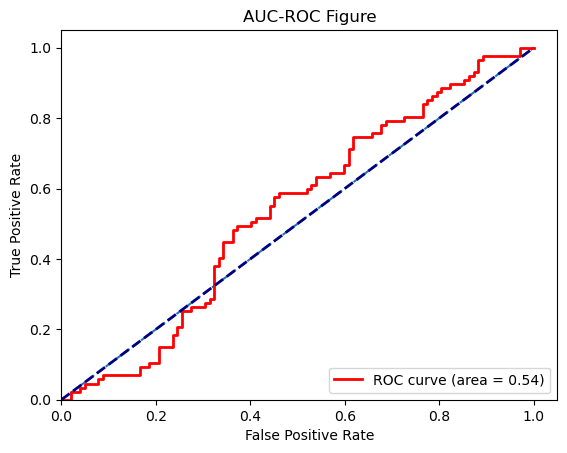

In [21]:
import matplotlib.pyplot as plt
# 生成对角线的x坐标和y坐标
x_diag = np.linspace(0, 1, num=100)
y_diag = x_diag

plt.plot(x_diag, y_diag, linestyle='--')  # 添加对角线参考线
plt.plot(fpr, tpr, color="red", lw=2,  label='ROC curve (area = %.2f)' % auc_score)
plt.plot([0,1],[0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Figure')
plt.legend(loc='lower right')
plt.savefig("./VAE_ROC.png")
plt.show()